# Imports

In [3]:
import sys
import os
import math

import time
import datetime as dt

import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import combinations

# GPU properties

In [4]:
torch.cuda.get_device_properties(torch.cuda)

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=3901MB, multi_processor_count=14)

In [5]:
# print(torch.cuda.memory_summary())

# Enable model differentiation by X

In [6]:
class diff_model_enable:
  def __init__(self, model, X):
    self.model = model
    self.X = X
  
  def __enter__(self):
    self.X.requires_grad = True
  
  def __exit__(self, exc_type, exc_val, exc_tb):
    self.X.requires_grad = False

In [7]:
def diff2(f, X):
  grads = torch.autograd.grad(
    outputs=f, inputs=X, grad_outputs=torch.ones_like(f),
    create_graph=True
  )[0]
  grad_grad = []
  for i in range(X.shape[1]):
    df = grads[:,i]
    df2 = torch.autograd.grad(
      outputs=df, inputs=X, grad_outputs=torch.ones_like(df),
      create_graph=True
    )[0][:,i]
    grad_grad.append(df2)
  return torch.stack(grad_grad, dim=1)

# Metropolis sampler

In [8]:
class MetropolisSampler():
  """Class for Metropolis sampler"""

  def __init__(self, dim1, dim2, epsilon=0.1, device='cpu'):
    self.epsilon = epsilon
    self.device = device
    self.sample = self.initialSample(dim1, dim2)

  def initialSample(self, dim1, dim2) -> torch.Tensor:
    return 3 * (
      torch.rand(
        (
          dim1, dim2
        )
      ) - 0.5
    ).to(self.device)
    
  def updateSampleBasOnDistrDens(self, __distributionDensity):
    newSample = self.sample + self.epsilon * (
      2 * torch.rand_like(
        self.sample,
        device=self.device
      ) - 1
    )
    critVal = __distributionDensity(newSample) / __distributionDensity(self.sample)
    doesPointMove = (torch.rand(len(self.sample), device=self.device) <= critVal)
    newSample = (
      torch.mul(doesPointMove.int(), newSample.t()).t()
      + torch.mul((1 - doesPointMove.int()), self.sample.t()).t()
    )
    self.sample = newSample

  def updateAndGetSample(self, __distributionDensity):
    for i in range(10):
      self.updateSampleBasOnDistrDens(__distributionDensity)
    return self.sample

# Integrate

In [9]:
def integrate(f, x: torch.Tensor, density) -> torch.Tensor:
  return torch.mean(f / density) #* torch.mean(density)

# Trial function

In [10]:
class TrialFunction(nn.Module):
  def __init__(self, dim_coord, num_states, potential, name,
               num_hidden_layers=3, num_hidden_neurons=60,
               init_mean_weights=0.0, init_std_weights=math.sqrt(0.1),
               activ_fnc=nn.Tanh()):
    super(TrialFunction, self).__init__()
    
    self.dim_coord = dim_coord
    self.num_states = num_states
    self.potential = potential

    self.name = name
    
    self.num_hidden_layers = num_hidden_layers
    self.num_hidden_neurons = num_hidden_neurons
    self.activ_fnc = activ_fnc
    # Layers
    self.layers = nn.Sequential()
    self.layers.append(nn.Linear(dim_coord, num_hidden_neurons))
    self.layers.append(activ_fnc)
    for layer in range(num_hidden_layers-1):
      self.layers.append(nn.Linear(num_hidden_neurons, num_hidden_neurons))
      self.layers.append(activ_fnc)
    # Gaussian weights
    self.gaussian_weights = nn.Linear(dim_coord, num_hidden_neurons, bias=False)
    # Out layer
    self.out_layer = nn.ModuleList(
      [nn.Linear(num_hidden_neurons, 1, bias=False) for state in range(num_states)]
    )
    # Initialise weigths
    self.init_weights(init_mean_weights, init_std_weights)

  def init_weights(self, init_mean_weights, init_std_weights):
    for layer in range(len(self.layers)):
      if 'weight' in dir(self.layers[layer]):
        nn.init.normal_(self.layers[layer].weight, init_mean_weights, init_std_weights)
      if 'bias' in dir(self.layers[layer]):
        nn.init.normal_(self.layers[layer].bias, init_mean_weights, init_std_weights)

    nn.init.sparse_(self.gaussian_weights.weight, sparsity=0.1, std=init_std_weights)

    for layer in range(len(self.out_layer)):
      if 'weight' in dir(self.out_layer[layer]):
        nn.init.normal_(
          self.out_layer[layer].weight, 
          1.0/math.sqrt(self.num_hidden_neurons), #init_mean_weights, 
          0.01 #init_std_weights
        )

  def forward(self, x):
    z = self.layers(x)
    
    sqr_gauss_weights = self.gaussian_weights.weight*self.gaussian_weights.weight
    gauss_kernel = torch.exp(-torch.matmul(x*x, torch.transpose(sqr_gauss_weights, 0, 1)))

    z_prime = gauss_kernel * z
    return [psi_n(z_prime) for psi_n in self.out_layer]

  def weigth_function(self, x):
    forward_ = self.forward(x)
    result = torch.zeros(len(x)).to(x.device)
    for psi_n in forward_:
      result += psi_n.squeeze(1) ** 2
    result /= len(forward_)
    return result #/ sum(result)

# Losses

In [11]:
def cache_psi(cache_dict):
  def wrapped(func):
    id_val = cache_dict
    def inner(*args):
      curr = id(args[0])
      if curr not in id_val:
        id_val[curr] = func(*args)
      return id_val[curr]
    return inner
  return wrapped  

CacheHamilt = dict()
@cache_psi(CacheHamilt)
def Hamiltonian(psi, x, potential):
  return (
    -0.5 * torch.sum(diff2(psi, x), dim=1).unsqueeze(1)
    + (potential(x) * psi.squeeze(1)).unsqueeze(1)
  )

CacheRayleigh = dict()
@cache_psi(CacheRayleigh)
def Rayleigh(psi, x, potential, density):
  return (
    integrate(psi*Hamiltonian(psi, x, potential), x, density)
    / integrate(psi*psi, x, density)
  )

def SqrResidual(output, x, potential, density):
  return sum(
    integrate((Hamiltonian(psi, x, potential) - Rayleigh(psi, x, potential, density)*psi)**2, x, density)
    / integrate(psi*psi, x, density) for psi in output
  )

def SqrResidualForPsi(psi, x, potential, density):
  return (
    integrate((Hamiltonian(psi, x, potential) - Rayleigh(psi, x, potential)*psi)**2, x, density)
    / integrate(psi*psi, x, density)
  ) 

def NormCond(trial_fnc):
  return sum((torch.sum(A*A, dim=1) - 1)**2 for A in trial_fnc.out_layer.parameters())

def OrthogonCond(output, x, density):
  result = []
  for psi_n, psi_m in combinations(output, 2):
    result += [(
      torch.square(integrate(psi_n*psi_m, x, density)) 
      / integrate(psi_n*psi_n, x, density) 
      / integrate(psi_m*psi_m, x, density)
    )]
  return sum(result)

# Checkpoint

In [12]:
def save_checkpoint(model, optimizer, step, loss):
  checkpoint = {
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
    'step' : step,
    'loss' : loss
  }
  fn = f"checkpoints/{model.name}.pt"
  torch.save(checkpoint, fn)

# Test (Helium atom)

In [13]:
dim_coord = 6
num_states = 3
potential = lambda x: (
  -2/torch.sqrt(torch.sum(x[:,:3]**2, dim=1))
  -2/torch.sqrt(torch.sum(x[:,3:]**2, dim=1))
  +1/torch.sqrt(torch.sum((x[:,:3]-x[:,3:])**2, dim=1))
)
num_hidden_layers = 3
num_hidden_neurons = 60
init_mean_weights = 0.0
init_std_weights = math.sqrt(0.1)
activ_fnc = nn.Tanh()

alpha = 2
beta = 1
gamma = 40 #1e4
delta = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
S = 2000
sampler = MetropolisSampler(dim1=S, dim2=dim_coord, epsilon=0.1, device=device)

lr = 1e-3
weight_decay = 5e-4

CHECKPOINT_PERIOD = 10

MAX_SQR_RESIDUAL = 1e-3

load_checkpoint = False

name = "test_He"

In [14]:
START_TIME = time.time()
  
hist = {
  'time' : list(),
  'loss' : list(),
  'sqr res' : list(),
  'norm cond' : list(),
  'orthogon cond' : list(),
  'bound cond' : list(),
}
for state in range(num_states):
  hist[f"Rayleigh{state}"] = list()
for state in range(num_states):
  hist[f"sqr_res_per_state{state}"] = list()

model = TrialFunction(dim_coord, num_states, potential, name,
               num_hidden_layers, num_hidden_neurons,
               init_mean_weights, init_std_weights,
               activ_fnc).to(device)

optimizer = torch.optim.Adam(
  params=list(model.parameters()),
  lr=lr,
  weight_decay=weight_decay
)

loss_weight = nn.Linear(1,4,bias=False).to(device)
nn.init.ones_(loss_weight.weight)
# loss_weight.weight.squeeze(1)#.shape

optimizer_loss_weight = torch.optim.Adam(
  params=list(loss_weight.parameters()),
  lr=1e2,#lr,
  maximize=True
)

if load_checkpoint:
  checkpoint = torch.load(f"checkpoints/{model.name}.pt")
  model.load_state_dict(checkpoint['model_state_dict'])
  model.train()
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  step = checkpoint['step']
  loss = checkpoint['loss']
  print(f"Load model and optimizer: step {checkpoint['step']}, loss {checkpoint['loss']}")
  # history
  hist_df = pd.read_csv(f"history/{model.name}.csv")
  hist['time'] = hist_df['time'].to_list()
  hist['loss'] = hist_df['loss'].to_list()
  hist['sqr res'] = hist_df['sqr res'].to_list()
  hist['norm cond'] = hist_df['norm cond'].to_list()
  hist['orthogon cond'] = hist_df['orthogon cond'].to_list()
  hist['bound cond'] = hist_df['bound cond'].to_list()
  for state in range(num_states):
    hist[f"Rayleigh{state}"] = hist_df[f"Rayleigh{state}"].to_list()
  for state in range(num_states):
    hist[f"sqr_res_per_state{state}"] = hist_df[f"sqr_res_per_state{state}"].to_list()

x = sampler.updateAndGetSample(model.weigth_function)
step = 0

valid_states = 0
while (valid_states < num_states):
  step += 1
  x = sampler.updateAndGetSample(model.weigth_function)

  loss_weight_l2 = torch.sum(loss_weight.weight**2)
  alpha = loss_weight.weight[0]**2 / loss_weight_l2
  beta = loss_weight.weight[1]**2 / loss_weight_l2
  gamma = loss_weight.weight[2]**2 / loss_weight_l2
  delta = loss_weight.weight[3]**2 / loss_weight_l2

  with diff_model_enable(model, x):
    output = model(x)
    density = model.weigth_function(x)
    
    sqr_residual = SqrResidual(output, x, potential, density)
    
    energies = [Rayleigh(psi, x, potential, density) for psi in output]
    energ_cond = sum(energies)
    
    norm_cond = NormCond(model)
    
    orthogon_cond = OrthogonCond(output, x, density)

    # Boundary conditions
    x1 = torch.zeros_like(x)
    x1[:,3:] = x[:,3:]

    x2 = torch.zeros_like(x)
    x2[:,:3] = x[:,:3]

    x3 = torch.ones_like(x) * x
    x3[:,3:] = x3[:,:3]

    L = 40
    x4 = (torch.randn_like(x) - 0.5) * L * 2
    for i in range(len(x4)):
      x4[i,i%6] = L
    
    bound_cond = sum(
      sum(torch.stack(model(x1), dim=0)**2)
      + sum(torch.stack(model(x2), dim=0)**2)
      + sum(torch.stack(model(x3), dim=0)**2)
      + sum(torch.stack(model(x4), dim=0)**2)
    )
    
    loss = (
      sqr_residual 
      + alpha * energ_cond 
      + beta * norm_cond 
      + gamma * orthogon_cond * 100
      + delta * bound_cond
    )

    loss_1 = (
      sqr_residual**2
      + alpha * energ_cond**2
      + beta * norm_cond**2
      + gamma * orthogon_cond**2
      + delta * bound_cond**2
      - 1
    )**2
    
    sqr_res_per_state = [SqrResidualForPsi(psi, x, potential, density) for psi in output]
    valid_states = sum(sqr_res_per_state_ < MAX_SQR_RESIDUAL for sqr_res_per_state_ in sqr_res_per_state)

    optimizer.zero_grad()
    optimizer_loss_weight.zero_grad()
    loss.backward()
    optimizer.step()
    optimizer_loss_weight.step()
  
  CacheRayleigh.clear()
  CacheHamilt.clear()

  hist['time'] += [time.time() - START_TIME]
  hist['loss'] += [loss.item()]
  hist['sqr res'] += [sqr_residual.item()]
  hist['norm cond'] += [norm_cond.item()]
  hist['orthogon cond'] += [orthogon_cond.item()]
  hist['bound cond'] += [bound_cond.item()]
  for state in range(num_states):
    hist[f"Rayleigh{state}"] += [energies[state].item()]
    hist[f"sqr_res_per_state{state}"] += [sqr_res_per_state[state].item()]

  if step == 1:
    header = (
        "step, time, loss, sqr res,"
        + " norm cond, orthogon cond, bound cond"
    )
    for i in range(num_states):
      header += f", Rayleigh{i}"
    for i in range(num_states):
      header += f", sqr_res_per_state{i}"
    print(header)
  
  if (step % CHECKPOINT_PERIOD) == 0 or step == 1:            
    info = (
      f"{step}, "
      + f"{time.time() - START_TIME:.2f}, "
      + f"{loss.item():.2e}, "
      + f"{sqr_residual.item():.2e}, "
      + f"{norm_cond.item():.2e}, "
      + f"{orthogon_cond.item():.2e}, "
      + f"{bound_cond.item():.2e}"
    )
    for Rayleigh_ in energies:
      info += f", {Rayleigh_.item():.2e}"
    for sqr_res_per_state_ in sqr_res_per_state:
      info += f", {sqr_res_per_state_.item():.2e}"
    print(info)
      
    hist_df = pd.DataFrame(data=hist)
    hist_df.to_csv(f"history/{model.name}.csv")

    save_checkpoint(model, optimizer, step, loss)

step, time, loss, sqr res, norm cond, orthogon cond, bound cond, Rayleigh0, Rayleigh1, Rayleigh2, sqr_res_per_state0, sqr_res_per_state1, sqr_res_per_state2
1, 0.74, 1.03e+03, 1.39e+01, 2.45e-03, 2.97e+00, 3.79e+03, -7.32e-01, -7.77e-01, -7.04e-01, 4.69e+00, 4.58e+00, 4.58e+00
10, 1.92, 2.82e+02, 1.51e+01, 4.81e-03, 2.96e+00, 7.43e+02, 3.74e-01, 3.44e-01, 3.55e-01, 5.00e+00, 5.00e+00, 5.05e+00
20, 3.25, 1.90e+02, 1.07e+01, 1.81e-02, 2.98e+00, 4.01e+02, 3.53e-01, 3.50e-01, 3.21e-01, 3.56e+00, 3.59e+00, 3.54e+00
30, 4.58, 1.43e+02, 8.18e+00, 3.43e-02, 2.98e+00, 2.27e+02, 3.02e-01, 3.20e-01, 2.98e-01, 2.72e+00, 2.78e+00, 2.68e+00
40, 5.91, 1.18e+02, 7.30e+00, 4.74e-02, 2.98e+00, 1.35e+02, 3.38e-01, 3.71e-01, 3.33e-01, 2.41e+00, 2.46e+00, 2.43e+00
50, 7.24, 1.10e+02, 6.18e+00, 5.88e-02, 2.98e+00, 1.06e+02, 2.49e-01, 2.95e-01, 2.41e-01, 2.02e+00, 2.12e+00, 2.05e+00
60, 8.59, 1.04e+02, 5.65e+00, 6.76e-02, 2.97e+00, 8.25e+01, 2.11e-01, 2.58e-01, 2.12e-01, 1.84e+00, 1.92e+00, 1.88e+00
70, 9.94

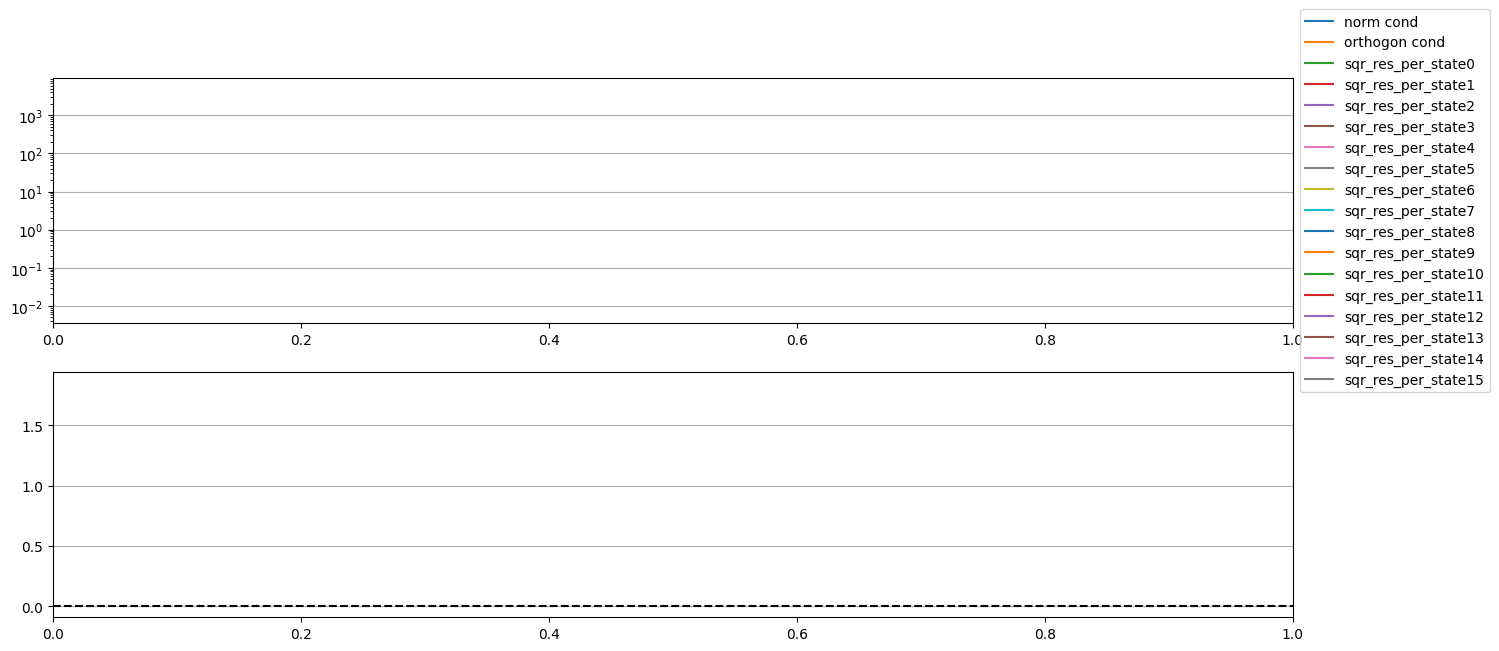

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.read_csv("history/test_HO.csv")
xmax = len(hist)
xmin = 0 #xmax - 1000

fig, ax = plt.subplots(2,1,figsize=(16,7))

hist[['norm cond','orthogon cond']][xmin:xmax].plot(xlim=(xmin, xmax), ax = ax[0])
hist[[f"sqr_res_per_state{s}" for s in range(16)]][xmin:xmax].plot(xlim=(xmin, xmax), ax = ax[0])
# ax[0].plot(np.arange(xmin,xmax), np.sum(hist[[f'Rayleigh{i}' for i in range(16)]][xmin:xmax].to_numpy(), axis=1))
ax[0].set_yscale('log')
ax[0].grid(axis='y')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

hist[[f'Rayleigh{i}' for i in range(16)]][xmin:xmax].plot(xlim=(xmin, xmax), legend=False, ax = ax[1], alpha=0.7)
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].grid(axis='y')
# ax[1].set_yscale('symlog')

In [ ]:
print(f"{torch.cuda.temperature():} °C")
!! nvidia-smi